# How to fit a Gaussian Process

In this tutorial we will learn, how to fit a Gaussian process to noisy data points.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import bask
from bask import BayesGPR
plt.style.use('bmh')
colors = plt.cm.get_cmap("Set1").colors

## Generate the dataset
First we start by simulating our 1d toy dataset:

In [2]:
rand = np.random.RandomState(123)
n_points = 100
noise = 1.
frequency = 3.
X = rand.uniform(-1, 1, size=n_points)[:, None]
y = np.sin(X * frequency).flatten() + rand.randn(n_points) * noise

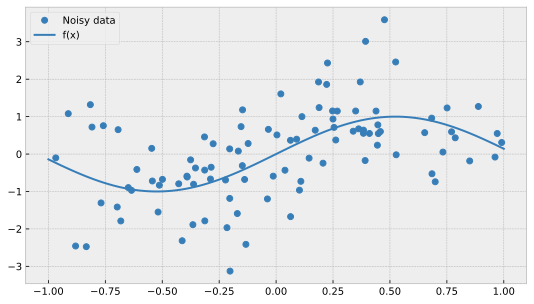

In [3]:
fig, ax = plt.subplots(figsize=(9, 5))
xx = np.linspace(-1, 1, num=100)
yy = np.sin(xx * frequency)
ax.plot(X, y, "o", color=colors[1], label="Noisy data")
ax.plot(xx, yy, color=colors[1], label="f(x)")
plt.legend(loc=2);

## Fitting the Gaussian process
In order to fit a Gaussian process, we need to specify:

1. the (composite) kernel to be used
2. the prior distributions for the kernel hyperparameters

Here we choose Matérn kernel with initial length scale of 1.0:

In [4]:
from skopt.learning.gaussian_process.kernels import Matern
from scipy.stats import invgamma, halfnorm
kernel = 1.0 ** 2 + Matern(length_scale=1., length_scale_bounds=(0.1, 2.))

The length scale specifies how smooth the target function is. Larger length scales correspond to smooth functions whereas small length scales produce more frequently varying functions.

The `1.0 ** 2` implicitly defines a `ConstantKernel` for the signal variance, which defines how much the actual target function varies.
The given bounds restrict the length scale which the initial maximum marginal likelihood estimate can produce.

Don’t worry, all these kernel hyperparameters will be inferred using Markov Chain Monte Carlo (MCMC). These are just the initial values.
You might wonder, where we model the noise of the function. The appropriate `WhiteKernel` will be added by the `BayesGPR` internally and we do not need to add it manually.

What is left, is the definition of the kernel parameter prior distributions:

In [5]:
priors = [
    # Prior distribution for the signal variance:
    lambda x: halfnorm(scale=2.).logpdf(np.sqrt(np.exp(x))) + x / 2.0 - np.log(2.0),
    # Prior distribution for the length scale:
    lambda x: invgamma(a=9, scale=11).logpdf(np.exp(x)) + x,
    # Prior distribution for the noise:
    lambda x: halfnorm(scale=2.).logpdf(np.sqrt(np.exp(x))) + x / 2.0 - np.log(2.0)
]

For the signal variance and noise, a half-normal distribution is vague enough to not bias the inference too strongly, while still regularizing the parameters towards 0.
Specifying a prior distribution for the length scale is more difficult (due to identifiability issues in both directions). Here we use an inverse gamma distribution, which limits the prior probability weight of small length scales and decays more gradual for large length scales.

With that we have all necessary ingredients to be able to fit our GP:

In [6]:
%%time
gp = BayesGPR(kernel=kernel, normalize_y=True, random_state=rand)
gp.fit(X, y, n_desired_samples=100, n_burnin=100, progress=False, priors=priors)

Wall time: 1min 3s


We can visualize the Gaussian process by plotting the GP mean process and the standard errors and deviations:

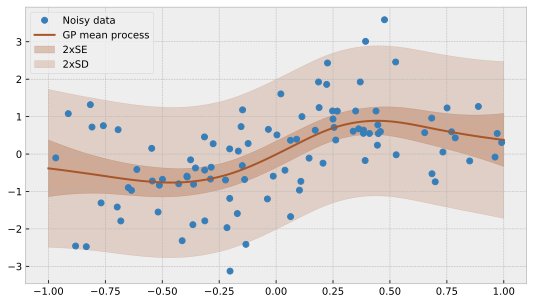

In [7]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(X, y, "o", color=colors[1], zorder=2, label="Noisy data")
xx = np.linspace(-1, 1, num=100)[:, None]
with gp.noise_set_to_zero():
    yy, yy_ste = gp.predict(xx, return_std=True)
_, yy_std = gp.predict(xx, return_std=True)
ax.plot(xx, yy, color=colors[6], zorder=3, label="GP mean process")
ax.fill_between(xx.flatten(), yy-yy_ste*1.96, yy+yy_ste * 1.96, alpha=0.3, color=colors[6], zorder=1,
                label="2xSE")
ax.fill_between(xx.flatten(), yy-yy_std*1.96, yy+yy_std * 1.96, alpha=0.2, color=colors[6], zorder=0,
                label="2xSD")
plt.legend(loc=2);

To sample GP realizations using the best fit (geometric median) Gaussian process,
we make use of the `sample_y` function:

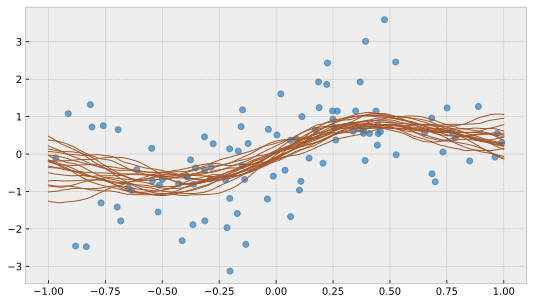

In [8]:
xx = np.linspace(-1, 1, num=200)[:, None]
YY = gp.sample_y(xx, n_samples=20, sample_mean=True)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(X, y, "o", color=colors[1], zorder=2, label="Noisy data", alpha=0.7)

ax.plot(xx, YY, color=colors[6], zorder=3, label="GP realizations", linewidth=1.);

We can also simulate function realizations using the complete posterior distribution, by setting `sample_mean=False`:

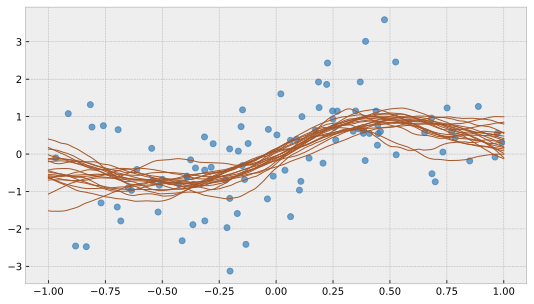

In [9]:
xx = np.linspace(-1, 1, num=200)[:, None]
YY = gp.sample_y(xx, n_samples=20, sample_mean=False)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(X, y, "o", color=colors[1], zorder=2, label="Noisy data", alpha=0.7)

ax.plot(xx, YY, color=colors[6], zorder=3, label="GP realizations", linewidth=1.);

As is apparent, the latter realizations are much more chaotic, since the kernel hyperparameters vary for each realization.